### Description: This script will plot the reforecast for a specific basin

#### Step 1: Import Libraries

In [1]:
import datetime
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import gcsfs

#### Step 2: Load Files

In [2]:
# Function for opening zarr datasets
def open_zarr(path):
  return xr.open_zarr(
      store=path,
      chunks=None,
      storage_options=dict(token='anon')
      )

In [3]:
# Set file paths
base_directory = 'gs://flood-forecasting/hydrologic_predictions/model_id_8583a5c2_v0/'
reforecast_path = os.path.join(base_directory, 'reforecast/streamflow.zarr/')
reanalysis_path = os.path.join(base_directory, 'reanalysis/streamflow.zarr/')
return_periods_path = os.path.join(base_directory, 'return_periods.zarr/')

In [4]:
# Load files
reforecast_ds = open_zarr(reforecast_path)
reanalysis_ds = open_zarr(reanalysis_path)
return_periods_ds = open_zarr(return_periods_path)

print(f'{reforecast_ds.sizes = }')
print(f'{reanalysis_ds.sizes = }')
print(f'{return_periods_ds.sizes = }')

C:\Users\Mark.DESKTOP-UFHIN6T\AppData\Local\Temp\ipykernel_26976\3731592437.py:3: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  return xr.open_zarr(


reforecast_ds.sizes = Frozen({'gauge_id': 1031646, 'issue_time': 2738, 'lead_time': 8})
reanalysis_ds.sizes = Frozen({'gauge_id': 1031646, 'time': 16063})
return_periods_ds.sizes = Frozen({'gauge_id': 1031646})


#### Step 3: Load for a HydroBasin 

In [5]:
hybas_id = "hybas_1121183290" # South of Hola (Tana River), Kenya
gauge_reforecast_ds = reforecast_ds.sel(gauge_id=hybas_id).compute()
gauge_reanalysis_ds = reanalysis_ds.sel(gauge_id=hybas_id).compute()
gauge_return_periods_ds = return_periods_ds.sel(gauge_id=hybas_id).compute()

#### Step 4: Plot Forecast

In [6]:
# What issue date are we interested in?
issue_date = pd.to_datetime('2020-04-18')

In [7]:
# Shift reanalyis by a day because Reanalysis[time=T] == Reforecast[time=T+1, lead_time=0]
gauge_reanalysis_ds_shifted = gauge_reanalysis_ds.assign_coords(time=gauge_reanalysis_ds.time + pd.Timedelta(days=1))
# Extract reanalysis streamflow for week before and after the issue date
reanalysis_pre = gauge_reanalysis_ds_shifted.sel(time=slice(issue_date - pd.Timedelta(weeks=1), issue_date))
reanalysis_post = gauge_reanalysis_ds_shifted.sel(time=slice(issue_date, issue_date + pd.Timedelta(weeks=1))) 
# Extract reforecast for chosen issue date
reforecast_plot = gauge_reforecast_ds.sel(issue_time=issue_date)
# Extract thresholds
normal = (0, float(gauge_return_periods_ds.return_period_2))
warning = (float(gauge_return_periods_ds.return_period_2), float(gauge_return_periods_ds.return_period_5))
danger = (float(gauge_return_periods_ds.return_period_5), float(gauge_return_periods_ds.return_period_20))
extreme = (float(gauge_return_periods_ds.return_period_20), float(gauge_return_periods_ds.return_period_200))
# Extract forecasts
forecast_dates = []
forecast_streamflows = []
for L in range(0, 8):
    forecast_dates.append(issue_date + pd.Timedelta(days=L))
    forecast_streamflows.append(float(reforecast_plot.streamflow.sel(lead_time=f"{L} days")))

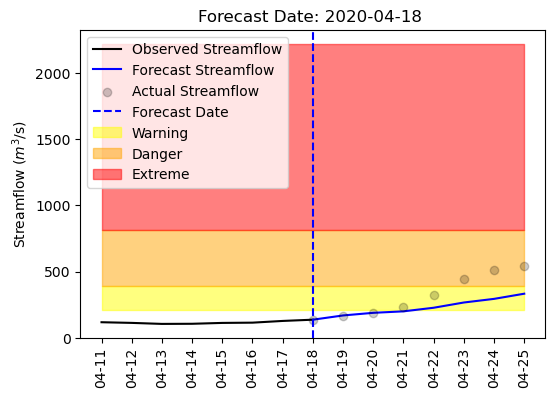

In [9]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(reanalysis_pre.time, reanalysis_pre.streamflow, color='black', label='Observed Streamflow', zorder=3)
ax.plot(forecast_dates, forecast_streamflows, color='blue', label='Forecast Streamflow', zorder=3)
ax.scatter(reanalysis_post.time, reanalysis_post.streamflow, color='black', label='Actual Streamflow', alpha=0.2, zorder=3)

ax.axvline(issue_date, color='blue', linestyle='--', label='Forecast Date', zorder=3)
# Add thresholds
all_dates = np.concatenate((reanalysis_pre.time, reanalysis_post.time), axis=0)
ax.fill_between(all_dates, warning[0], warning[1], alpha=0.5, color='yellow', label="Warning", zorder=1)
ax.fill_between(all_dates, danger[0], danger[1], alpha=0.5, color='orange', label="Danger", zorder=1)
ax.fill_between(all_dates, extreme[0], extreme[1], alpha=0.5, color='red', label="Extreme", zorder=1)

# Styling 
# Set major ticks to every day
ax.xaxis.set_major_locator(mdates.DayLocator())
# Format the tick labels to show date in the desired format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
# Rotate tick labels vertically
plt.ylabel(r'Streamflow ($m^3$/s)')
# plt.xlabel('Date')
plt.xticks(rotation=90)
plt.legend(loc="upper left")
plt.title(f'Forecast Date: {issue_date.strftime('%Y-%m-%d')} ')
plt.show()